In [9]:
import mitsuba as mi
import drjit as dr
import numpy as np
import matplotlib.pyplot as plt
from sionna.rt import load_scene, RadioMapSolver

from scene_objects import create_scene_objects
from motion_engine import MotionEngine

# Set Mitsuba variant
mi.set_variant("llvm_ad_mono_polarized")

In [10]:
scene_path = r"C:\Users\sawyer\Documents\sionna_rt_jamming\data\downtown_chicago\DowntownChicago1KM.xml"
scene = load_scene(scene_path)

In [11]:
bounds, map_center, map_size, cell_size = create_scene_objects(scene)
map_width, map_height = map_size

In [12]:
engine = MotionEngine(scene, bounds=bounds)

# Add jammer paths
engine.add_random_walk("Tx1", starting_position=[70, -10, 10], num_steps=3, step_size=10.0, time_step=1.0)
engine.add_random_walk("Tx2", starting_position=[-260, 100, 10], num_steps=5, step_size=10.0, time_step=1.0)

# Create synchronized padded paths
padded_paths, max_steps = engine.create_path_matrix(padding_mode='pad_end')

Generated path for 'Tx1': Total distance: 20.00 m, Avg velocity: 10.00 m/s
Generated path for 'Tx2': Total distance: 40.00 m, Avg velocity: 10.00 m/s
Padded 'Tx1' from 3 to 5 steps (mode: pad_end)


Tx1 position: [70.0, -10.0, 10.0]
Tx2 position: [-260.0, 100.0, 10.0]
Tx1 position: [78.8, -5.2, 10.0]
Tx2 position: [-258.5, 90.1, 10.0]
Tx1 position: [81.8, -14.7, 10.0]
Tx2 position: [-268.0, 87.1, 10.0]
Tx2 position: [-268.5, 97.1, 10.0]
Tx2 position: [-258.6, 95.3, 10.0]


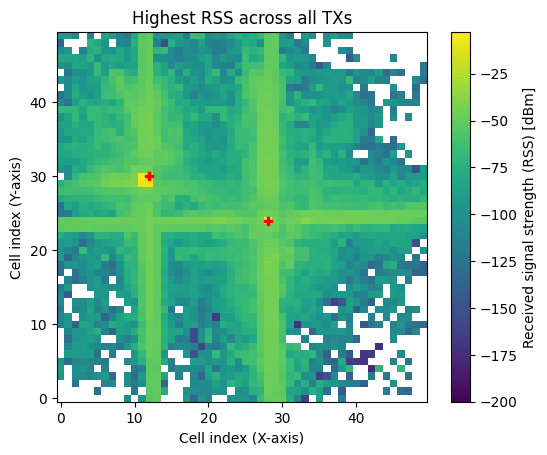

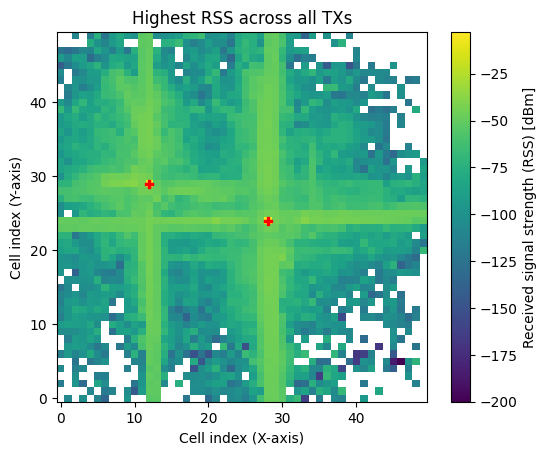

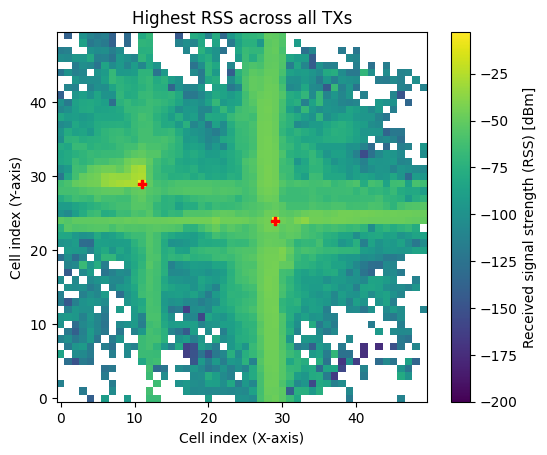

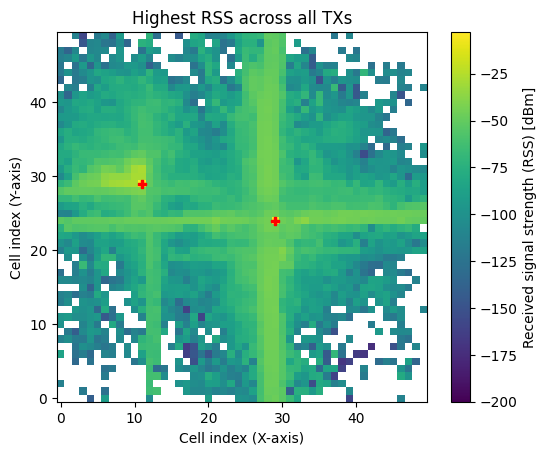

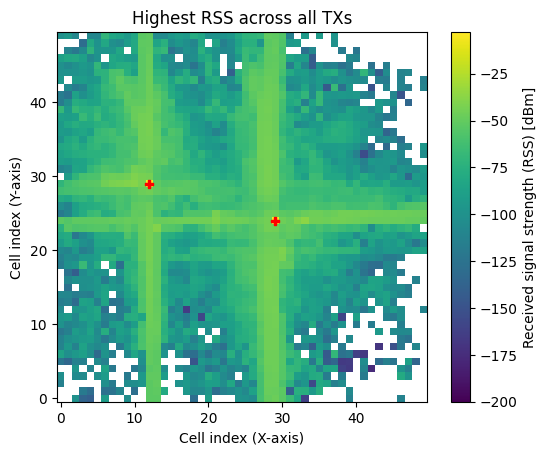

In [13]:
rm_solver = RadioMapSolver()

for step in range(max_steps):
    # Update transmitter positions
    engine.update_scene_transmitters(step)
    
    # Print current positions
    positions = engine.get_all_positions_at_step(step)
    for jammer_id, pos in positions.items():
        print(f"{jammer_id} position: [{pos[0]:.1f}, {pos[1]:.1f}, {pos[2]:.1f}]")
    
    # Compute radio map
    rm = rm_solver(
        scene,
        max_depth=10,
        samples_per_tx=10**6,  # Adjust for speed/memory
        cell_size=cell_size,
        center=map_center,
        size=[map_width, map_height],
        orientation=[0, 0, 0],
        diffraction=True,
        refraction=True,
        edge_diffraction=True
    )
    
    # Display radio map
    rm.show(metric="rss", tx=None, show_tx=True, vmin=-200)

In [14]:
print(padded_paths)

{'Tx1': array([[ 70.        , -10.        ,  10.        ],
       [ 78.75774537,  -5.17279625,  10.        ],
       [ 81.76833077, -14.70885285,  10.        ],
       [ 81.76833077, -14.70885285,  10.        ],
       [ 81.76833077, -14.70885285,  10.        ]]), 'Tx2': array([[-260.        ,  100.        ,   10.        ],
       [-258.48257594,   90.11579926,   10.        ],
       [-268.02995474,   87.14131476,   10.        ],
       [-268.46871802,   97.13168446,   10.        ],
       [-258.6402604 ,   95.28739034,   10.        ]])}
